In [2]:
include("LiPoSID.jl")
using QuantumOptics
basis = NLevelBasis(2)
using LinearAlgebra
using Plots
using StatsPlots
using Dates
using HDF5

In [3]:
function propagate(A, x0, steps)
    
    x = []
    push!(x, x0)

    @assert size(x0,1) == size(A,1) == size(A,2)

    for i=2:steps
        push!(x, A * x[end])
    end

    return x
end 

function bloch(ρ_list)
    # Pauli matricies
    σ = [ [0 1; 1 0], [0 -im; im 0], [1 0; 0 -1], [1 0; 0 1] ]

    bloch_vec = [
        convert.(Float64, [ ρ[1,2]+ρ[2,1],
                           (ρ[1,2]-ρ[2,1])*im,
                            ρ[1,1]-ρ[2,2]       ])
                for ρ in ρ_list]
    hcat(bloch_vec...)
end

bloch (generic function with 1 method)

In [4]:
data_dir = "DATA/"
ρᵉ, tᵉ = LiPoSID.get_rho_series(data_dir*"State_B2_2CUT_data.h5", "0.079477")
bloch(ρᵉ)

3×1256 Matrix{Float64}:
  0.0        0.0       0.0       0.0       …  -1.42428e-7  -4.44906e-7
  0.0        0.0       0.0       0.0           6.51954e-7   5.50602e-7
 -0.993332  -0.99024  -0.98695  -0.983554      0.730631     0.731017

In [8]:
function LMEvs4D_BlochDMD(γᵢ)
    data_dir = "DATA/"

    γᵢ = string(γᵢ)

    if γᵢ == "0.0" 
        ρᵉ, tᵉ = LiPoSID.get_rho_series(data_dir*"State_B2_2CUT_data.h5", "0.079477")
        ρᵍ, tᵍ = LiPoSID.get_rho_series(data_dir*"State_B1_2CUT_data.h5", "0.079477")
        ρˣ, tˣ = LiPoSID.get_rho_series(data_dir*"State_B3_2CUT_data.h5", "0.079477")
        ρʸ, tʸ = LiPoSID.get_rho_series(data_dir*"State_B4_2CUT_data.h5", "0.079477")
    else 
        ρᵉ, tᵉ = LiPoSID.get_rho_series(data_dir*"State_B2_2CUT_data.h5", γᵢ)
        ρᵍ, tᵍ = LiPoSID.get_rho_series(data_dir*"State_B1_2CUT_data.h5", γᵢ)
        ρˣ, tˣ = LiPoSID.get_rho_series(data_dir*"State_B3_2CUT_data.h5", γᵢ)
        ρʸ, tʸ = LiPoSID.get_rho_series(data_dir*"State_B4_2CUT_data.h5", γᵢ)
    end

    lᵉ = length(ρᵉ); lᵍ = length(ρᵍ); lˣ = length(ρˣ); lʸ = length(ρʸ)
    lᵐᵃˣ = min(lᵉ, lᵍ,  lˣ, lʸ)  #choose time limit by shortest series

    bᵉ = bloch(ρᵉ[1:lᵐᵃˣ])
    bᵍ = bloch(ρᵍ[1:lᵐᵃˣ])
    bˣ = bloch(ρˣ[1:lᵐᵃˣ])
    bʸ = bloch(ρʸ[1:lᵐᵃˣ])

    ω = 25.126

    Hᴸᴹᴱ = [ ω        0
             0        0   ]
    
    γ = parse(Float64, γᵢ)

    Aᴸᴹᴱ = [ 0    √γ
             0     0. + 0im  ]

    tᵉᶠ = convert.(Float64, tᵉ); tᵍᶠ = convert.(Float64, tᵍ); 
    tˣᶠ = convert.(Float64, tˣ); tʸᶠ = convert.(Float64, tʸ); 

    t = tˣᶠ

    ρᵉᴸᴹᴱ = LiPoSID.Lindblad_time_evolution(basis, ρᵉ[1], tᵉᶠ, Hᴸᴹᴱ, [Aᴸᴹᴱ])
    ρᵍᴸᴹᴱ = LiPoSID.Lindblad_time_evolution(basis, ρᵍ[1], tᵍᶠ, Hᴸᴹᴱ, [Aᴸᴹᴱ])
    ρˣᴸᴹᴱ = LiPoSID.Lindblad_time_evolution(basis, ρˣ[1], tˣᶠ, Hᴸᴹᴱ, [Aᴸᴹᴱ])
    ρʸᴸᴹᴱ = LiPoSID.Lindblad_time_evolution(basis, ρʸ[1], tʸᶠ, Hᴸᴹᴱ, [Aᴸᴹᴱ])

    bᵉᴸᴹᴱ = LiPoSID.bloch(ρᵉᴸᴹᴱ[1:lᵐᵃˣ])
    bᵍᴸᴹᴱ = LiPoSID.bloch(ρᵍᴸᴹᴱ[1:lᵐᵃˣ])
    bˣᴸᴹᴱ = LiPoSID.bloch(ρˣᴸᴹᴱ[1:lᵐᵃˣ])
    bʸᴸᴹᴱ = LiPoSID.bloch(ρʸᴸᴹᴱ[1:lᵐᵃˣ])


    Yᵉ = [bᵉᴸᴹᴱ; ones(length(tᵉᶠ))']
    Yᵍ = [bᵍᴸᴹᴱ; ones(length(tᵍᶠ))']
    Yˣ = [bˣᴸᴹᴱ; ones(length(tˣᶠ))']
    Yʸ = [bʸᴸᴹᴱ; ones(length(tʸᶠ))']

    Yᵉ⁻ = Yᵉ[:,1:end-1]; Yᵉ⁺ = Yᵉ[:,2:end]
    Yᵍ⁻ = Yᵍ[:,1:end-1]; Yᵍ⁺ = Yᵍ[:,2:end]
    Yˣ⁻ = Yˣ[:,1:end-1]; Yˣ⁺ = Yˣ[:,2:end]
    Yʸ⁻ = Yᵉ[:,1:end-1]; Yʸ⁺ = Yᵉ[:,2:end]

    Y⁻ = hcat(Yᵉ⁻, Yᵍ⁻, Yˣ⁻, Yʸ⁻)
    Y⁺ = hcat(Yᵉ⁺, Yᵍ⁺, Yˣ⁺, Yʸ⁺)

    #A⁴ᴰ = Y⁺ * pinv(Y⁻) 

    #Ac⁴ᴰ = [  - γ/2     -ω     0   0   # This is better 0.9999999993089329
    #            ω     -γ/2     0   0
    #            0.     0      -γ   γ
    #            0      0       0   0]

    Ac⁴ᴰ = [    0     -ω     0   0      # This is also good 0.9999890166421603
                ω     -γ     0   0
                0.     0    -γ   γ
                0      0     0   0 ]

    Δt = t[2] - t[1]

    A⁴ᴰ = exp(Ac⁴ᴰ * Δt) 
      
    bᵉ⁴ᴰ = hcat(propagate(A⁴ᴰ, [bᵉ[:,1]...,1], length(t))...)[1:3,:] 
    bᵍ⁴ᴰ = hcat(propagate(A⁴ᴰ, [bᵍ[:,1]...,1], length(t))...)[1:3,:]
    bˣ⁴ᴰ = hcat(propagate(A⁴ᴰ, [bˣ[:,1]...,1], length(t))...)[1:3,:]
    bʸ⁴ᴰ = hcat(propagate(A⁴ᴰ, [bʸ[:,1]...,1], length(t))...)[1:3,:]

    ρᵉ⁴ᴰ = LiPoSID.rho_series_from_bloch(bᵉ⁴ᴰ) 
    ρᵍ⁴ᴰ = LiPoSID.rho_series_from_bloch(bᵍ⁴ᴰ)
    ρˣ⁴ᴰ = LiPoSID.rho_series_from_bloch(bˣ⁴ᴰ)
    ρʸ⁴ᴰ = LiPoSID.rho_series_from_bloch(bʸ⁴ᴰ)

    #Fᵉ = LiPoSID.fidelity_series(basis, ρᵉᴸᴹᴱ[1:lᵐᵃˣ], ρᵉ⁴ᴰ[1:lᵐᵃˣ])
    #Fᵍ = LiPoSID.fidelity_series(basis, ρᵍᴸᴹᴱ[1:lᵐᵃˣ], ρᵍ⁴ᴰ[1:lᵐᵃˣ])
    #Fˣ = LiPoSID.fidelity_series(basis, ρˣᴸᴹᴱ[1:lᵐᵃˣ], ρˣ⁴ᴰ[1:lᵐᵃˣ])
    #Fʸ = LiPoSID.fidelity_series(basis, ρʸᴸᴹᴱ[1:lᵐᵃˣ], ρʸ⁴ᴰ[1:lᵐᵃˣ])

    Fᵉ = LiPoSID.fidelity_series(basis, ρᵉᴸᴹᴱ[1:lᵐᵃˣ], ρᵉ[1:lᵐᵃˣ])
    Fᵍ = LiPoSID.fidelity_series(basis, ρᵍᴸᴹᴱ[1:lᵐᵃˣ], ρᵍ[1:lᵐᵃˣ])
    Fˣ = LiPoSID.fidelity_series(basis, ρˣᴸᴹᴱ[1:lᵐᵃˣ], ρˣ[1:lᵐᵃˣ])
    Fʸ = LiPoSID.fidelity_series(basis, ρʸᴸᴹᴱ[1:lᵐᵃˣ], ρʸ[1:lᵐᵃˣ])

    return [Fᵉ, Fᵍ, Fˣ, Fʸ], t[1:lᵐᵃˣ]
    
end   

LMEvs4D_BlochDMD (generic function with 1 method)

In [6]:
data_dir = "DATA/"
ρᵉ, tᵉ = LiPoSID.get_rho_series(data_dir*"State_B2_2CUT_data.h5", "0.079477")
bloch(ρᵉ)

3×1256 Matrix{Float64}:
  0.0        0.0       0.0       0.0       …  -1.42428e-7  -4.44906e-7
  0.0        0.0       0.0       0.0           6.51954e-7   5.50602e-7
 -0.993332  -0.99024  -0.98695  -0.983554      0.730631     0.731017

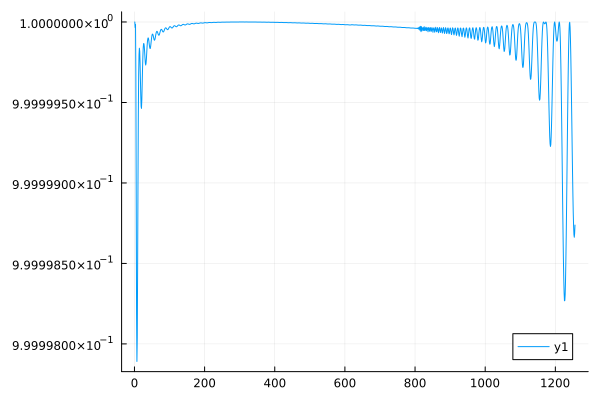

In [9]:
F, t = LMEvs4D_BlochDMD("0.079477")
plot(F[1])

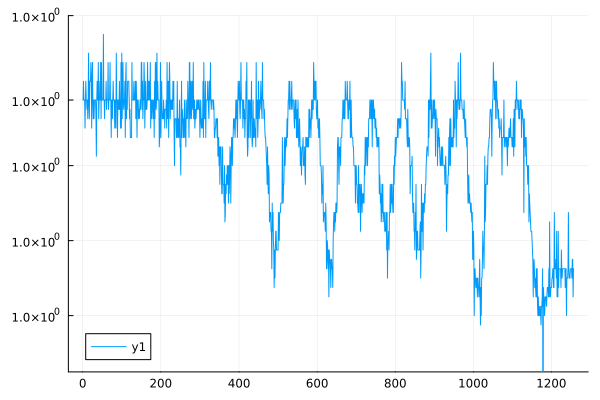

GKS: Possible loss of precision in routine SET_WINDOW


In [19]:
F, t = LMEvs4D_BlochDMD("0.079477")
plot(F[1])

In [20]:
minimum(F[1])

0.9999999999999964

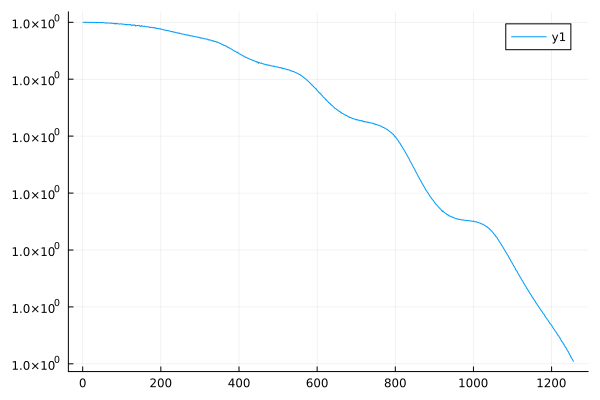

In [21]:
plot(F[2])

In [22]:
minimum(F[2])

0.9999999999994043

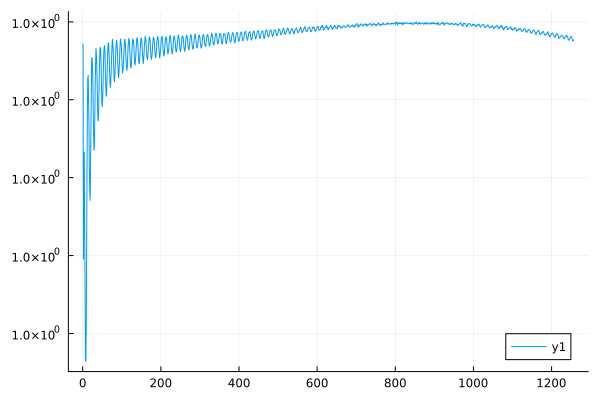

In [23]:
plot(F[3])

In [25]:
minimum(F[3])

0.9999999999995642

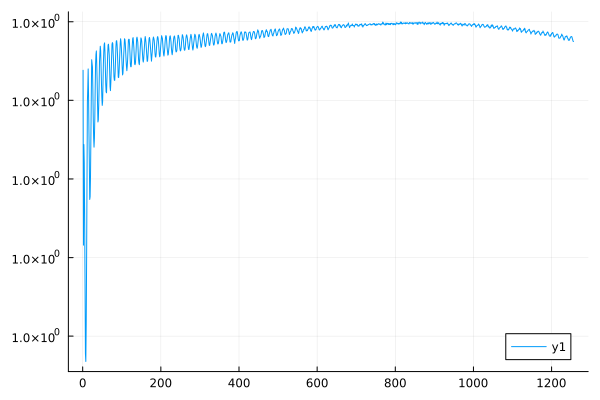

In [26]:
plot(F[4])

In [28]:
minimum(F[4])

0.9999999999995679